# Prepare

In [2]:
from google.colab import drive 
drive.mount('/content/gdrive/')

!cp -r '/content/gdrive/My Drive/data' .

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
!python --version

Python 3.6.9


Import some libraries

In [3]:
import json
import os, re
import pandas as pd
import numpy as np
import time
import random
from tqdm.notebook import tqdm
import torch
import matplotlib.pyplot as plt

Define important methods

In [4]:
def load_jsonl(jsonl):
    with open(jsonl, 'r') as file:
        return [json.loads(line) for line in list(file)]
    
def load_json(file):
    with open(file, 'r') as f:
        return json.load(f)

In [5]:
def mmmm(table, result):
    for feature in table.keys():
        result[feature + '_mean'] = np.mean(table[feature])
        result[feature + '_median'] = np.median(table[feature])
        result[feature + '_max'] = np.max(table[feature])
        result[feature + '_min'] = np.min(table[feature])

In [6]:
def make_string(d, use=['context', 'question', 'answer']):
  res = []
  if 'context' in use:
    res.append("Context: " + d['context'])
  if 'question' in use:
    res.append("Question: " + d['question'])
  if 'answer' in use:
    res.append("Answer: " + d['answer'])
  return ' [SEP] '.join(res) + ' [SEP]'

In [7]:
def make_dataset(d):
  X, y = [], []
  for i in simplify_data(d, remove_number=True):
    X.append(make_string(i))
    y.append(i['label'])
  return X, y

# Load

In [8]:
raw_validation, raw_train, raw_test = load_jsonl('data/val.jsonl'), load_jsonl('data/train.jsonl'), load_jsonl('data/test.jsonl')

In [9]:
for corpus in raw_validation + raw_train:
  corpus['is_answered'] = True
for corpus in raw_test:
  corpus['is_answered'] = False

In [10]:
data = raw_train + raw_validation + raw_test

Восстанавливаем индексы

In [11]:
context_index = 0
question_index = 0
answer_index = 0
for idx, item in enumerate(data):
  item['old_idx'] = item['idx']
  item['idx'] = context_index
  context_index += 1
  for q in item['passage']['questions']:
    q['old_idx'] = q['idx']
    q['idx'] = question_index
    question_index += 1
    for answer in q['answers']:
      answer['old_idx'] = answer['idx']
      answer['idx'] = answer_index
      answer_index += 1

# Analyse

In [12]:
amounts = {}
for i in data:
  if i['is_answered']:
    for question in i['passage']['questions']:
      right_answers_amount = sum(map(lambda answer: answer['label'], question['answers']))
      if right_answers_amount in amounts:
        amounts[right_answers_amount] += 1
      else:
        amounts[right_answers_amount] = 0

Text(0, 0.5, 'Amount')

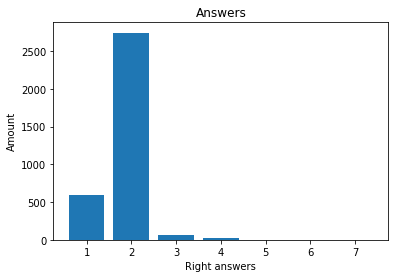

In [13]:
x = amounts.keys()
y = amounts.values()
plt.bar(x, y)
plt.title("Answers")
plt.xlabel("Right answers")
plt.ylabel("Amount")

In [14]:
fractions = {}
for i in data:
  if i['is_answered']:
    for question in i['passage']['questions']:
      fraction = sum(map(lambda answer: answer['label'], question['answers'])) / len(question['answers'])
      if fraction in fractions:
        fractions[fraction] += 1
      else:
        fractions[fraction] = 0

Text(0, 0.5, 'Amount')

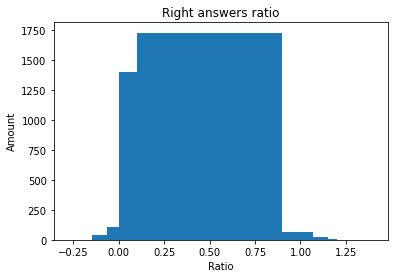

In [15]:
x = fractions.keys()
y = fractions.values()
plt.bar(x, y)
plt.title("Right answers ratio")
plt.xlabel("Ratio")
plt.ylabel("Amount")

# Translate

Load translation dictionaries

In [16]:
translated_answers, translated_questions, translated_texts = load_json('data/answers.json'), load_json('data/questions.json'), load_json('data/texts.json')

In [17]:
translated_questions['Почему медвежонок решил уйти из дома?'] = "Why did the teddy bear decide to leave home?"

In [18]:
def translate(text, kind='text'):
    if kind == 'text':
        return translated_texts[text]
    elif kind == 'question':
        return translated_questions[text]
    elif kind == 'answer':
        return translated_answers[text]

Translate data

In [19]:
for item in data:
    passage = item['passage']
    questions = passage['questions']
    passage['text'] = translate(passage['text'], kind='text')
    for question_idx, question in enumerate(questions):
        questions[question_idx]['question'] = translate(question['question'], kind='question')
        answers = question['answers']
        for answer_idx, answer in enumerate(answers):
            answers[answer_idx]['text'] = translate(answer['text'], kind='answer')

# Make flatten

In [20]:
def remove_sentence_number(s):
  return re.sub('\(\d+\)[ ]*', '', s)

In [21]:
def simplify_data(d, split_answers=False, split_questions=True):
  simplified = []
  temp = {}
  for item in d:
    temp['context'] = remove_sentence_number(item['passage']['text'])
    temp['context_idx'] = item['idx']
    temp['context_old_idx'] = item['old_idx']
    temp['is_answered'] = item['is_answered']
    if split_questions:
      for question in item['passage']['questions']:
        temp['question'] = question['question']
        temp['qustion_idx'] = question['idx']
        temp['question_old_idx'] = question['old_idx']
        if split_answers:
          for answer in question['answers']:
            temp['answer'] = answer['text']
            temp['answer_idx'] = answer['idx']
            temp['answer_old_idx'] = answer['old_idx']
            temp['label'] = answer['label'] if 'label' in answer else None
            simplified.append(temp.copy())
        else:
          temp['answers'] = question['answers']
          simplified.append(temp.copy())
    else:
        temp = {}

        temp['context'] = remove_sentence_number(item['passage']['text'])
        temp['questions'] = item['passage']['questions']
        temp['is_answered'] = item['is_answered']
        simplified.append(temp.copy())
  return simplified

In [22]:
train = pd.DataFrame(list(simplify_data(data, split_answers=True))).set_index('answer_idx')

In [23]:
temp = {'questions_set': [], 'answers_tuple': []}
for corpus in simplify_data(data, split_questions=False):
  questions = corpus['questions']
  for question in questions:
    answers = question['answers']
    for answer in answers:
      temp['questions_set'].append(list(map(lambda x: x['idx'], questions)))
      temp['answers_tuple'].append(list(map(lambda x: x['idx'], answers)))
train['questions_set'] = temp['questions_set']
train['answers_tuple'] = temp['answers_tuple']

In [24]:
train.head()

,context,context_idx,context_old_idx,is_answered,question,qustion_idx,question_old_idx,answer,answer_old_idx,label,questions_set,answers_tuple
answer_idx,,,,,,,,,,,,
0,"But people cannot exist without nature, so the...",0,0,True,Where did the punks run?,0,0,In the park.,0,1.0,"[0, 1, 2, 3, 4, 5, 6, 7, 8]","[0, 1, 2]"
1,"But people cannot exist without nature, so the...",0,0,True,Where did the punks run?,0,0,In the woods.,1,0.0,"[0, 1, 2, 3, 4, 5, 6, 7, 8]","[0, 1, 2]"
2,"But people cannot exist without nature, so the...",0,0,True,Where did the punks run?,0,0,Near the entrance.,2,0.0,"[0, 1, 2, 3, 4, 5, 6, 7, 8]","[0, 1, 2]"
3,"But people cannot exist without nature, so the...",0,0,True,Why did Luda hit Artyom?,1,1,He pestered her.,3,1.0,"[0, 1, 2, 3, 4, 5, 6, 7, 8]","[3, 4, 5]"
4,"But people cannot exist without nature, so the...",0,0,True,Why did Luda hit Artyom?,1,1,He insulted her.,4,0.0,"[0, 1, 2, 3, 4, 5, 6, 7, 8]","[3, 4, 5]"


# Baseline that *is bullshit*

In [ ]:
!pip install transformers
!pip install tensorboardx
!pip install simpletransformers

In [ ]:
from simpletransformers.classification import ClassificationModel

In [ ]:
X_train, y_train = make_dataset(train)

train_df = pd.DataFrame({
    'text': X_train,
    'label':y_train
})

In [ ]:
# Create a TransformerModel
model = ClassificationModel('bert', 'bert-base-multilingual-uncased',use_cuda=True)

# Train the model
model.train_model(train_df)

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model 

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


(1774, 0.6914106750232929)

In [ ]:
X_test, y_test = make_dataset(test)
predictions, raw_outputs = model.predict(X_test)

# Pipeline

In [25]:
!pip install transformers
!pip install sentencepiece
!pip install catboost

     |████████████████████████████████| 1.5MB 5.9MB/s 
     |████████████████████████████████| 2.9MB 29.9MB/s 
     |████████████████████████████████| 890kB 29.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=2c123a1d764b2e0f1b58dceb6ac63a725700e687ae6c61d2ccf7f2627739fbb3
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 1.1MB 4.2MB/s 
     |████████████████████████████████| 66.3MB 42kB/s 


In [26]:
from transformers import pipeline

In [27]:
classifier = pipeline("zero-shot-classification", model='facebook/bart-large-mnli', device=0)

Some weights of the model checkpoint at facebook/bart-large-mnli were not used when initializing BartModel: ['model.encoder.version', 'model.decoder.version']
- This IS expected if you are initializing BartModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BartModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Some weights of the model checkpoint at facebook/bart-large-mnli were not used when initializing BartForSequenceClassification: ['model.encoder.version', 'model.decoder.version']
- This IS expected if you are initializing BartForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BartForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [28]:
temp = {}
for corpus in tqdm(simplify_data(data, split_answers=False)):
  question = corpus['question']
  answers = [(answer['idx'], answer['text']) for answer in corpus['answers']]
  sentence = make_string(corpus, use=['context', 'question'])
  raw_result = classifier(sentence, list(map(lambda answer: answer['text'], corpus['answers'])))
  temp_answers = answers.copy()
  result = {}
  for i in list(zip(raw_result['labels'], raw_result['scores'])):
    for j in range(len(temp_answers)):
      if i[0] == temp_answers[j][1]:
        id = temp_answers.pop(j)[0]
        result[id] = i[1]
        break
  for idx, answer in answers:
    temp[idx] = result[idx]

In [41]:
pd.concat([pd.DataFrame([{'answer_idx': i[0], 'facebook/mnli': i[1]} for i in temp.items()]).set_index('answer_idx'), train], axis=1)

,facebook/mnli,context,context_idx,context_old_idx,is_answered,question,qustion_idx,question_old_idx,answer,answer_old_idx,label,questions_set,answers_tuple
answer_idx,,,,,,,,,,,,,
0,0.876531,"But people cannot exist without nature, so the...",0,0,True,Where did the punks run?,0,0,In the park.,0,1.0,"[0, 1, 2, 3, 4, 5, 6, 7, 8]","[0, 1, 2]"
1,0.042271,"But people cannot exist without nature, so the...",0,0,True,Where did the punks run?,0,0,In the woods.,1,0.0,"[0, 1, 2, 3, 4, 5, 6, 7, 8]","[0, 1, 2]"
2,0.081198,"But people cannot exist without nature, so the...",0,0,True,Where did the punks run?,0,0,Near the entrance.,2,0.0,"[0, 1, 2, 3, 4, 5, 6, 7, 8]","[0, 1, 2]"
3,0.836539,"But people cannot exist without nature, so the...",0,0,True,Why did Luda hit Artyom?,1,1,He pestered her.,3,1.0,"[0, 1, 2, 3, 4, 5, 6, 7, 8]","[3, 4, 5]"
4,0.145226,"But people cannot exist without nature, so the...",0,0,True,Why did Luda hit Artyom?,1,1,He insulted her.,4,0.0,"[0, 1, 2, 3, 4, 5, 6, 7, 8]","[3, 4, 5]"


,facebook/mnli
answer_idx,
0,0.876531
1,0.042271
2,0.081198
3,0.836539
4,0.145226
...,...
21794,0.497972
21795,0.528383
21796,0.044430


In [ ]:
train.head(10)

,context,context_idx,is_answered,question,qustion_idx,answer,label,questions_set,answers_tuple
answer_idx,,,,,,,,,
0,"But people cannot exist without nature, so the...",0,True,Where did the punks run?,0,In the park.,1.0,"[0, 1, 2, 3, 4, 5, 6, 7, 8]","[0, 1, 2]"
1,"But people cannot exist without nature, so the...",0,True,Where did the punks run?,0,In the woods.,0.0,"[0, 1, 2, 3, 4, 5, 6, 7, 8]","[0, 1, 2]"
2,"But people cannot exist without nature, so the...",0,True,Where did the punks run?,0,Near the entrance.,0.0,"[0, 1, 2, 3, 4, 5, 6, 7, 8]","[0, 1, 2]"
3,"But people cannot exist without nature, so the...",0,True,Why did Luda hit Artyom?,1,He pestered her.,1.0,"[0, 1, 2, 3, 4, 5, 6, 7, 8]","[3, 4, 5]"
4,"But people cannot exist without nature, so the...",0,True,Why did Luda hit Artyom?,1,He insulted her.,0.0,"[0, 1, 2, 3, 4, 5, 6, 7, 8]","[3, 4, 5]"
5,"But people cannot exist without nature, so the...",0,True,Why did Luda hit Artyom?,1,The car accidentally fell.,0.0,"[0, 1, 2, 3, 4, 5, 6, 7, 8]","[3, 4, 5]"
6,"But people cannot exist without nature, so the...",0,True,How did the guys have fun in the park?,2,We ran to the library and back.,0.0,"[0, 1, 2, 3, 4, 5, 6, 7, 8]","[6, 7, 8, 9, 10]"
7,"But people cannot exist without nature, so the...",0,True,How did the guys have fun in the park?,2,"They drank, gambled, fought and filmed girls.",1.0,"[0, 1, 2, 3, 4, 5, 6, 7, 8]","[6, 7, 8, 9, 10]"
8,"But people cannot exist without nature, so the...",0,True,How did the guys have fun in the park?,2,We walked the dogs.,0.0,"[0, 1, 2, 3, 4, 5, 6, 7, 8]","[6, 7, 8, 9, 10]"


In [ ]:
answers

In [ ]:
results = pd.DataFrame(results)
results.head(10)

In [ ]:
for idx, answer, label in row['answer']:
  print(idx, answer, label)

11925 Dagestan ". 1
11926 Cheetah". 0
11927 Tatarstan ". 0
11928 Patrol ship "Dagestan". 1
11929 Landing ship "Volgodonsk". 0


In [ ]:
row['answer']

In [ ]:
results

In [ ]:
dict(zip([{answer: idx for idx, answer, label in row['answer']}[answer] for answer in result['labels']], result['scores']))

In [ ]:
result = pd.DataFrame(results).set_index('idx')

In [ ]:
result = result.drop_duplicates(subset=['answer', 'question', 'context'])

In [ ]:
len(result)

3422

In [ ]:
len(list(simplify_data(train)))

14185

In [ ]:
pd.DataFrame(results).set_index('idx').loc[pd.DataFrame(results).set_index('idx')['label'] == 1].head(10)

In [ ]:
ind = 0

In [ ]:
a = list(simplify_data(train, keep_answers=True))[ind]

In [ ]:
s = make_string(a, use=['text', 'question'])

In [ ]:
classifier(s, a['answer'])

In [ ]:
list(map(lambda x: x['text'] + " " + str(x['label']), train[1]['passage']['questions'][ind-7]['answers']))

IndexError: ignored

# RoBERTa and BERT

In [ ]:
!pip install transformers

In [ ]:
from transformers import BertForQuestionAnswering, BertTokenizer

In [ ]:
!pip install hydra-core

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

In [ ]:
def bert_qa(text, question):
  input_ids = tokenizer.encode(question, text)
  tokens = tokenizer.convert_ids_to_tokens(input_ids)

  # Search the input_ids for the first instance of the `[SEP]` token.
  sep_index = input_ids.index(tokenizer.sep_token_id)

  # The number of segment A tokens includes the [SEP] token istelf.
  num_seg_a = sep_index + 1

  # The remainder are segment B.
  num_seg_b = len(input_ids) - num_seg_a

  # Construct the list of 0s and 1s.
  segment_ids = [0]*num_seg_a + [1]*num_seg_b

  outputs = model(torch.tensor([input_ids]), # The tokens representing our input text.
                            token_type_ids=torch.tensor([segment_ids])) # The segment IDs to differentiate question from answer_text

  start_scores = outputs.start_logits
  end_scores = outputs.end_logits
  
  # Find the tokens with the highest `start` and `end` scores.
  answer_start = torch.argmax(start_scores)
  answer_end = torch.argmax(end_scores)

  answer = tokens[answer_start]

  # Select the remaining answer tokens and join them with whitespace.
  for i in range(answer_start + 1, answer_end + 1):
    
    # If it's a subword token, then recombine it with the previous token.
    if tokens[i][0:2] == '##':
      answer += tokens[i][2:]
      
    # Otherwise, add a space then the token.
    else:
      answer += ' ' + tokens[i]

  return answer

In [ ]:
bert_qa('I am doggy.', 'Who am I?')

In [ ]:
import torch
roberta = torch.hub.load('pytorch/fairseq', 'roberta.large')
roberta.eval()  # disable dropout (or leave in train mode to finetune)

In [ ]:
!wget https://dl.fbaipublicfiles.com/fairseq/models/roberta.large.tar.gz
!tar -xzvf roberta.large.tar.gz

In [ ]:
from fairseq.models.roberta import RobertaModel
roberta = RobertaModel.from_pretrained('./roberta.large', checkpoint_file='model.pt')
roberta.eval()  # disable dropout (or leave in train mode to finetune)

In [ ]:
tokens = roberta.encode('Hello world!')
assert tokens.tolist() == [0, 31414, 232, 328, 2]
roberta.decode(tokens)  # 'Hello world!'

'Hello world!'

In [ ]:
# Extract the last layer's features
last_layer_features = roberta.extract_features(tokens)
assert last_layer_features.size() == torch.Size([1, 5, 1024])

# Extract all layer's features (layer 0 is the embedding layer)
all_layers = roberta.extract_features(tokens, return_all_hiddens=True)
assert len(all_layers) == 25
assert torch.all(all_layers[-1] == last_layer_features)

In [ ]:
# Download RoBERTa already finetuned for MNLI
roberta = torch.hub.load('pytorch/fairseq', 'roberta.large.mnli')
roberta.eval()  # disable dropout for evaluation

# Encode a pair of sentences and make a prediction
tokens = roberta.encode('Roberta is a heavily optimized version of BERT.', 'Roberta is not very optimized.')
roberta.predict('mnli', tokens).argmax()  # 0: contradiction

# Encode another pair of sentences
tokens = roberta.encode('Roberta is a heavily optimized version of BERT.', 'Roberta is based on BERT.')
roberta.predict('mnli', tokens).argmax()  # 2: entailment

In [ ]:
import torch
from fairseq.data.data_utils import collate_tokens

roberta = torch.hub.load('pytorch/fairseq', 'roberta.large.mnli')
roberta.eval()

batch_of_pairs = [
    ['Roberta is a heavily optimized version of BERT.', 'Roberta is not very optimized.'],
    ['Roberta is a heavily optimized version of BERT.', 'Roberta is based on BERT.'],
    ['potatoes are awesome.', 'I like to run.'],
    ['Mars is very far from earth.', 'Mars is very close.'],
]

batch = collate_tokens(
    [roberta.encode(pair[0], pair[1]) for pair in batch_of_pairs], pad_idx=1
)

logprobs = roberta.predict('mnli', batch)
print(logprobs.argmax(dim=1))
# tensor([0, 2, 1, 0])

In [ ]:
labels = {0: 'contradiction', 1: 'neutral', 2: 'entailment'}
def roberta_nls(text, statement):
  tokens = roberta.encode(text, statement)
  prediction = roberta.predict('mnli', tokens).argmax().item()
  return labels[prediction]

In [ ]:
label_map = {0: 'contradiction', 1: 'neutral', 2: 'entailment'}
ncorrect, nsamples = 0, 0
roberta.cuda()
roberta.eval()
with open('glue_data/MNLI/dev_matched.tsv') as fin:
    fin.readline()
    for index, line in enumerate(fin):
        tokens = line.strip().split('\t')
        sent1, sent2, target = tokens[8], tokens[9], tokens[-1]
        tokens = roberta.encode(sent1, sent2)
        prediction = roberta.predict('mnli', tokens).argmax().item()
        prediction_label = label_map[prediction]
        ncorrect += int(prediction_label == target)
        nsamples += 1
print('| Accuracy: ', float(ncorrect)/float(nsamples))
# Expected output: 0.9060

In [ ]:
roberta_nls("I love my dog!", "My dog loves me!")

In [ ]:
contradiction_right, contradiction_wrong, entailment_right, entailment_wrong = 0, 0, 0, 0

roberta.cuda()
roberta.eval()

for corpus in train:
  passage = corpus['passage']
  text = passage['text']
  for question_corpus in passage['questions']:
    question = question_corpus['question']
    bert_answer = bert_qa(text, question)
    for answer in question_corpus['answers']:
      label = answer['label']
      answer = answer['text']
      roberta_label = roberta_nls(bert_answer, answer)
      if roberta_label == 'entailment':
        if label == 1:
          entailment_right+=1
        else:
          entailment_wrong+=1
      elif roberta_label == 'contradiction':
        if label == 0:
          contradiction_right+=1
        else:
          contradiction_wrong+=1
  print("contradiction accuracy = " + str(contradiction_right / (contradiction_wrong + contradiction_right)), "entailment accuracy = " + str(entailment_right / (entailment_wrong + entailment_right)))

# MT-DNN


In [ ]:
!git clone https://github.com/microsoft/MT-DNN

In [ ]:
!pip install -e ./MT-DNN/

In [ ]:
%%writefile setup.sh

git clone https://github.com/NVIDIA/apex
pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./apex

In [ ]:
!sh setup.sh

In [ ]:
from mtdnn.common.types import EncoderModelType
from mtdnn.configuration_mtdnn import MTDNNConfig
from mtdnn.data_builder_mtdnn import MTDNNDataBuilder
from mtdnn.modeling_mtdnn import MTDNNModel
from mtdnn.process_mtdnn import MTDNNDataProcess
from mtdnn.tasks.config import MTDNNTaskDefs
from mtdnn.tokenizer_mtdnn import MTDNNTokenizer

In [ ]:
BATCH_SIZE = 16
MULTI_GPU_ON = True
MAX_SEQ_LEN = 128
NUM_EPOCHS = 5
config = MTDNNConfig(batch_size=BATCH_SIZE, 
                    max_seq_len=MAX_SEQ_LEN, 
                    multi_gpu_on=MULTI_GPU_ON)

In [ ]:
DATA_DIR = "./"
DATA_SOURCE_DIR = os.path.join(DATA_DIR, "MNLI")
tasks_params = {
                "mnli": {
                    "data_format": "PremiseAndOneHypothesis",
                    "encoder_type": "BERT",
                    "dropout_p": 0.3,
                    "enable_san": True,
                    "labels": ["contradiction", "neutral", "entailment"],
                    "metric_meta": ["ACC"],
                    "loss": "CeCriterion",
                    "kd_loss": "MseCriterion",
                    "n_class": 3,
                    "split_names": [
                        "train",
                        "dev_matched",
                        "dev_mismatched",
                        "test_matched",
                        "test_mismatched",
                    ],
                    "data_source_dir": DATA_SOURCE_DIR,
                    "data_process_opts": {"header": True, "is_train": True, "multi_snli": False,},
                    "task_type": "Classification",
                },
            }

# Define the tasks
task_defs = MTDNNTaskDefs(tasks_params)

In [ ]:
from transformers import BertForQuestionAnswering, BertModel, BertTokenizer
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

In [ ]:
comparing_model = BertModel.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad', return_dict=True)

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

In [ ]:
for item in train:
    passage = item['passage']
    questions = passage['questions']
    text = passage['text']
    for question in questions:
        answers = question['answers']
        input_ids = tokenizer.encode(question['question'], text)
        tokens = tokenizer.convert_ids_to_tokens(input_ids)

        # Search the input_ids for the first instance of the `[SEP]` token.
        sep_index = input_ids.index(tokenizer.sep_token_id)

        # The number of segment A tokens includes the [SEP] token istelf.
        num_seg_a = sep_index + 1

        # The remainder are segment B.
        num_seg_b = len(input_ids) - num_seg_a

        # Construct the list of 0s and 1s.
        segment_ids = [0]*num_seg_a + [1]*num_seg_b

        start_scores, end_scores = model(torch.tensor([input_ids]), # The tokens representing our input text.
                                 token_type_ids=torch.tensor([segment_ids])) # The segment IDs to differentiate question from answer_text
        # Find the tokens with the highest `start` and `end` scores.
        answer_start = torch.argmax(start_scores)
        answer_end = torch.argmax(end_scores)

        # Combine the tokens in the answer and print it out.
        answer = ' '.join(tokens[answer_start:answer_end+1])

        print("Question:", question['question'])

        print('BERT Answer: "' + answer + '"')

        print('TRULY Answers:', '\n' + '\n'.join(map(lambda x: x['text'], filter(lambda x: x['label'], answers))))
    break

In [ ]:
def similarity(x, y):
  normalize_a = tf.nn.l2_normalize(x,0)        
  normalize_b = tf.nn.l2_normalize(y,0)
  cos_similarity=tf.reduce_sum(tf.multiply(normalize_a,normalize_b))
  sess=tf.Session()
  cos_sim=sess.run(cos_similarity)
  return cos_sim

In [ ]:
for item in train:
    passage = item['passage']
    questions = passage['questions']
    text = passage['text']
    for question in questions:
        answers = question['answers']
        input_ids = tokenizer.encode(question['question'], text)
        tokens = tokenizer.convert_ids_to_tokens(input_ids)
        sep_index = input_ids.index(tokenizer.sep_token_id)
        num_seg_a = sep_index + 1
        num_seg_b = len(input_ids) - num_seg_a
        segment_ids = [0]*num_seg_a + [1]*num_seg_b
        start_scores, end_scores = model(torch.tensor([input_ids]), token_type_ids=torch.tensor([segment_ids]))
        answer_start = torch.argmax(start_scores)
        answer_end = torch.argmax(end_scores)
        bert_answer = ' '.join(tokens[answer_start:answer_end+1])
        bert_vector = model(**tokenizer(bert_answer, return_tensors="pt"))
        for variant in answers:
          variant_vector = model(**tokenizer(variant['text'], return_tensors="pt"))
          print('is_right = ' + str(variant['label']), 'similarity = ' + str(similarity(bert_vector, variant_vector)))
    break

In [ ]:
tf.nn.l2_normalize(bert_vector[0], 0)

In [ ]:
bert_vector

In [ ]:
variant_vector

In [ ]:
cosine_similarity(bert_vector[0].detach().numpy(), variant_vector[0].detach().numpy())

In [ ]:
question = "How many rabbits do I have?"
answer_text = "Hello! My name is Misha and I'm from Krasnoyarsk! I live in rabbit farm. In total, we have sixteen rabbits, but all of them has different wool colors, for instance, gray, brown, black and etc. I really enjoy countryside life!"

In [ ]:
input_ids = tokenizer.encode(question, answer_text)

print('The input has a total of {:} tokens.'.format(len(input_ids)))

In [ ]:
# BERT only needs the token IDs, but for the purpose of inspecting the 
# tokenizer's behavior, let's also get the token strings and display them.
tokens = tokenizer.convert_ids_to_tokens(input_ids)

# For each token and its id...
for token, id in zip(tokens, input_ids):
    
    # If this is the [SEP] token, add some space around it to make it stand out.
    if id == tokenizer.sep_token_id:
        print('')
    
    # Print the token string and its ID in two columns.
    print('{:<12} {:>6,}'.format(token, id))

    if id == tokenizer.sep_token_id:
        print('')
    

In [ ]:
# Search the input_ids for the first instance of the `[SEP]` token.
sep_index = input_ids.index(tokenizer.sep_token_id)

# The number of segment A tokens includes the [SEP] token istelf.
num_seg_a = sep_index + 1

# The remainder are segment B.
num_seg_b = len(input_ids) - num_seg_a

# Construct the list of 0s and 1s.
segment_ids = [0]*num_seg_a + [1]*num_seg_b

# There should be a segment_id for every input token.
assert len(segment_ids) == len(input_ids)

In [ ]:
# Run our example through the model.
start_scores, end_scores = model(torch.tensor([input_ids]), # The tokens representing our input text.
                                 token_type_ids=torch.tensor([segment_ids])) # The segment IDs to differentiate question from answer_text


In [ ]:
# Find the tokens with the highest `start` and `end` scores.
answer_start = torch.argmax(start_scores)
answer_end = torch.argmax(end_scores)

# Combine the tokens in the answer and print it out.
answer = ' '.join(tokens[answer_start:answer_end+1])

print('Answer: "' + answer + '"')